In [1]:
#from ray.rllib.env import PettingZooEnv
from pettingzoo.mpe import simple_adversary_v2

In [2]:
import numpy as np
import time

class MultiAgentReplayBuffer:
    def __init__(self, max_size, critic_dims, actor_dims, 
            n_actions, n_agents, batch_size):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.n_agents = n_agents
        self.actor_dims = actor_dims
        self.batch_size = batch_size
        self.n_actions = n_actions

        self.state_memory = np.zeros((self.mem_size, critic_dims))
        self.new_state_memory = np.zeros((self.mem_size, critic_dims))
        self.reward_memory = np.zeros((self.mem_size, n_agents))
        self.terminal_memory = np.zeros((self.mem_size, n_agents), dtype=bool)

        self.init_actor_memory()

    def init_actor_memory(self):
        self.actor_state_memory = []
        self.actor_new_state_memory = []
        self.actor_action_memory = []

        for i in range(self.n_agents):
            self.actor_state_memory.append(
                            np.zeros((self.mem_size, self.actor_dims[i])))
            self.actor_new_state_memory.append(
                            np.zeros((self.mem_size, self.actor_dims[i])))
            self.actor_action_memory.append(
                            np.zeros((self.mem_size, self.n_actions)))


    def store_transition(self, raw_obs, state, action, reward, 
                               raw_obs_, state_, done):
        # this introduces a bug: if we fill up the memory capacity and then
        # zero out our actor memory, the critic will still have memories to access
        # while the actor will have nothing but zeros to sample. Obviously
        # not what we intend.
        # In reality, there's no problem with just using the same index
        # for both the actor and critic states. I'm not sure why I thought
        # this was necessary in the first place. Sorry for the confusion!

        #if self.mem_cntr % self.mem_size == 0 and self.mem_cntr > 0:
        #    self.init_actor_memory()
        
        index = self.mem_cntr % self.mem_size

        for agent_idx in range(self.n_agents):
            self.actor_state_memory[agent_idx][index] = raw_obs[agent_idx]
            self.actor_new_state_memory[agent_idx][index] = raw_obs_[agent_idx]
            self.actor_action_memory[agent_idx][index] = action[agent_idx]

        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        states = self.state_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        actor_states = []
        actor_new_states = []
        actions = []
        for agent_idx in range(self.n_agents):
            actor_states.append(self.actor_state_memory[agent_idx][batch])
            actor_new_states.append(self.actor_new_state_memory[agent_idx][batch])
            actions.append(self.actor_action_memory[agent_idx][batch])

        return actor_states, states, actions, rewards, \
               actor_new_states, states_, terminal

    def ready(self):
        if self.mem_cntr >= self.batch_size:
            return True

In [3]:
np.random.uniform(-0.8, -0.6, 2)

array([-0.738963  , -0.62734982])

In [4]:
#world.adv_swarm_pos = []
import random

#downLeft = np.random.uniform(-0.8, -0.6, world.dim_p)
#upRight = np.random.uniform(0.8, 0.6, world.dim_p)
#world.adv_swarm_pos.append(downLeft)
#world.adv_swarm_pos.append(upRight)
rand_pos = random.choice([np.random.uniform(-0.8, -0.6, 2), np.random.uniform(0.8, 0.6, 2)])
rand_pos

array([0.72443209, 0.62819836])

In [5]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, 
                    n_agents, n_actions, name, chkpt_dir):
        super(CriticNetwork, self).__init__()

        self.chkpt_file = os.path.join(chkpt_dir, name)

        self.fc1 = nn.Linear(input_dims+n_agents*n_actions, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.q = nn.Linear(fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
 
        self.to(self.device)

    def forward(self, state, action):
        x = F.relu(self.fc1(T.cat([state, action], dim=1)), inplace=True)
        x = F.relu(self.fc2(x), inplace=True)
        q = self.q(x)

        return q

    def save_checkpoint(self):
        T.save(self.state_dict(), self.chkpt_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.chkpt_file))


class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, 
                 n_actions, name, chkpt_dir):
        super(ActorNetwork, self).__init__()

        self.chkpt_file = os.path.join(chkpt_dir, name)

        self.fc1 = nn.Linear(input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.pi = nn.Linear(fc2_dims, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
 
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state), inplace=True)
        x = F.relu(self.fc2(x), inplace=True)
        pi = T.softmax(self.pi(x), dim=1)

        return pi

    def save_checkpoint(self):
        T.save(self.state_dict(), self.chkpt_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.chkpt_file))

In [6]:
import torch as T
#from networks import ActorNetwork, CriticNetwork

class Agent:
    def __init__(self, actor_dims, critic_dims, n_actions, n_agents, agent_idx, chkpt_dir,
                    alpha=0.01, beta=0.01, fc1=64, 
                    fc2=64, gamma=0.95, tau=0.01):
        self.gamma = gamma
        self.tau = tau
        self.n_actions = n_actions
        self.agent_name = 'agent_%s' % agent_idx
        self.actor = ActorNetwork(alpha, actor_dims, fc1, fc2, n_actions, 
                                  chkpt_dir=chkpt_dir,  name=self.agent_name+'_actor')
        self.critic = CriticNetwork(beta, critic_dims, 
                            fc1, fc2, n_agents, n_actions, 
                            chkpt_dir=chkpt_dir, name=self.agent_name+'_critic')
        self.target_actor = ActorNetwork(alpha, actor_dims, fc1, fc2, n_actions,
                                        chkpt_dir=chkpt_dir, 
                                        name=self.agent_name+'_target_actor')
        self.target_critic = CriticNetwork(beta, critic_dims, 
                                            fc1, fc2, n_agents, n_actions,
                                            chkpt_dir=chkpt_dir,
                                            name=self.agent_name+'_target_critic')

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        actions = self.actor.forward(state)
        noise = T.rand(self.n_actions).to(self.actor.device)
        action = actions + noise

        return action.detach().cpu().numpy()[0]

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        target_actor_params = self.target_actor.named_parameters()
        actor_params = self.actor.named_parameters()

        target_actor_state_dict = dict(target_actor_params)
        actor_state_dict = dict(actor_params)
        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                    (1-tau)*target_actor_state_dict[name].clone()

        self.target_actor.load_state_dict(actor_state_dict)

        target_critic_params = self.target_critic.named_parameters()
        critic_params = self.critic.named_parameters()

        target_critic_state_dict = dict(target_critic_params)
        critic_state_dict = dict(critic_params)
        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                    (1-tau)*target_critic_state_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

In [7]:
import torch as T
import torch.nn.functional as F
#from agent import Agent

class MADDPG:
    def __init__(self, actor_dims, critic_dims, n_agents, n_actions, 
                 scenario='simple',  alpha=0.01, beta=0.01, fc1=64, 
                 fc2=64, gamma=0.99, tau=0.01, chkpt_dir='tmp/maddpg/'):
        self.agents = []
        self.n_agents = n_agents
        self.n_actions = n_actions
        chkpt_dir += scenario 
        for agent_idx in range(self.n_agents):
            self.agents.append(Agent(actor_dims[agent_idx], critic_dims,  
                            n_actions, n_agents, agent_idx, alpha=alpha, beta=beta,
                            chkpt_dir=chkpt_dir))


    def save_checkpoint(self):
        print('... saving checkpoint ...')
        for agent in self.agents:
            agent.save_models()

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        for agent in self.agents:
            agent.load_models()

    def choose_action(self, raw_obs):
        actions = []
        for agent_idx, agent in enumerate(self.agents):
            action = agent.choose_action(raw_obs[agent_idx])
            actions.append(action)
        return actions

    def learn(self, memory):
        if not memory.ready():
            return

        actor_states, states, actions, rewards, \
        actor_new_states, states_, dones = memory.sample_buffer()

        device = self.agents[0].actor.device

        states = T.tensor(states, dtype=T.float).to(device)
        actions = T.tensor(actions, dtype=T.float).to(device)
        rewards = T.tensor(rewards, dtype=T.float).to(device)
        states_ = T.tensor(states_, dtype=T.float).to(device)
        dones = T.tensor(dones).to(device)

        all_agents_new_actions = []
        all_agents_new_mu_actions = []
        old_agents_actions = []

        for agent_idx, agent in enumerate(self.agents):
            new_states = T.tensor(actor_new_states[agent_idx], 
                                 dtype=T.float).to(device)

            new_pi = agent.target_actor.forward(new_states)

            all_agents_new_actions.append(new_pi)
            mu_states = T.tensor(actor_states[agent_idx], 
                                 dtype=T.float).to(device)
            pi = agent.actor.forward(mu_states)
            all_agents_new_mu_actions.append(pi)
            old_agents_actions.append(actions[agent_idx])

        new_actions = T.cat([acts for acts in all_agents_new_actions], dim=1)
        mu = T.cat([acts for acts in all_agents_new_mu_actions], dim=1)
        old_actions = T.cat([acts for acts in old_agents_actions],dim=1)

        for agent_idx, agent in enumerate(self.agents):
            critic_value_ = agent.target_critic.forward(states_, new_actions).flatten()
            critic_value_[dones[:,0]] = 0.0
            critic_value = agent.critic.forward(states, old_actions).flatten()

            target = rewards[:,agent_idx] + agent.gamma*critic_value_
            
            critic_loss = F.mse_loss(target, critic_value)
            agent.critic.optimizer.zero_grad()
            critic_loss.backward(retain_graph=True)
            agent.critic.optimizer.step()

            actor_loss = agent.critic.forward(states, mu).flatten()
            actor_loss = -T.mean(actor_loss)
            agent.actor.optimizer.zero_grad()
            actor_loss.backward(retain_graph=True)
            agent.actor.optimizer.step()

            agent.update_network_parameters()

In [8]:
import numpy as np
#from maddpg import MADDPG
#from buffer import MultiAgentReplayBuffer

import gym
from gym.spaces import prng      
import pettingzoo # prng has been canceled

# and change:
#random_array = np.random.RandomState().rand(self.num_discrete_space)

from make_env import make_env


scenario = 'simple_adversary2'
env = make_env(scenario)
n_agents = env.n
actor_dims = []
for i in range(n_agents):
    actor_dims.append(env.observation_space[i].shape[0])
critic_dims = sum(actor_dims)
n_actions = env.action_space[1].sample()
n_actions

[3, 0]

In [9]:
a_list = [False, False, False]
False in a_list

True

In [10]:
#pip show gym
from platform import python_version
python_version()

'3.8.8'

In [11]:
#import numpy as np
np.random.uniform(-0.8, -0.6, 2)

array([-0.61469148, -0.72718312])

In [12]:
np.sqrt(np.sum(np.square(np.random.uniform(-0.8, -0.6, 2) - np.random.uniform(-0.5, +0.5, 2))))

1.1641013025137847

In [13]:
-min([0.1046235696735722, 0.9459605197053144, 1.2099744729757327])

-0.1046235696735722

In [14]:
-min([5, 5, 4, 2])

-2

In [15]:
-np.square(0.7 - 0.5)

-0.03999999999999998

In [16]:
ar1 = []
ar2 = [-0.69479192,  8.96625909]
ar3 = [-0.19479192,  9.46625909]

ar1.append(ar2)
ar1.append(ar3)

np.concatenate(ar1)
#ar1

array([-0.69479192,  8.96625909, -0.19479192,  9.46625909])

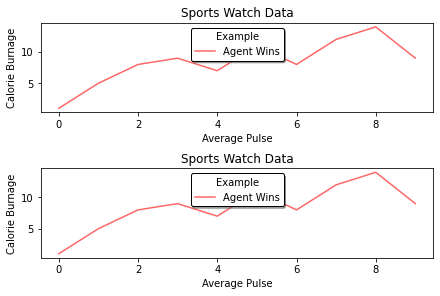

In [17]:
import matplotlib.pyplot as plt
#data-points or markers
values1 = [1, 5, 8, 9, 7, 11, 8, 12, 14, 9]
values2 = range(len(values1))
figure, axis  = plt.subplots(2, 1, constrained_layout=True)
#figure.tight_layout()
axis[0].plot(values2, values1, color='red',alpha=0.6)
axis[0].set_title("Sports Watch Data")
axis[0].set_xlabel("Average Pulse")
axis[0].set_ylabel("Calorie Burnage")
axis[0].legend(['Agent Wins','Adversary Wins'],facecolor='w',loc='upper center',shadow=True,edgecolor='black',title='Example')
axis[1].plot(values2, values1, color='red',alpha=0.6)
axis[1].set_title("Sports Watch Data")
axis[1].set_xlabel("Average Pulse")
axis[1].set_ylabel("Calorie Burnage")
axis[1].legend(['Agent Wins','Adversary Wins'],facecolor='w',loc='upper center',shadow=True,edgecolor='black',title='Example')
#plt.legend(['sine-wave','cosine-wave'],facecolor='w',loc='upper center',shadow=True,edgecolor='black',title='Example')


#plt.savefig('plot14.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
np.random.uniform(-0.8, -0.6, 2)

array([-0.66731308, -0.6978222 ])

In [19]:
agent = np.random.uniform(-0.8, -0.6, 2)
agent

array([-0.687606  , -0.70372087])

In [20]:
np.zeros(shape=(0,2))

array([], shape=(0, 2), dtype=float64)

In [21]:
import random
#agent.state.p_pos = np.random.uniform(-1, +1, world.dim_p)
adv_pos = []
#adv_pos = np.array([])
downLeft = np.random.uniform(-0.8, -0.6, 2)
upRight = np.random.uniform(0.8, 0.6, 2)
adv_pos.append(downLeft)
adv_pos.append(upRight)
rand_pos = random.choice(adv_pos)
#rand_pos_np = np.array(rand_pos)
             
#agent.state.p_pos = np.random.uniform(-0.8, -0.6, world.dim_p)
for i in range(3): 
    
    agent = rand_pos
    
    
    #print (agent)
agent

  

array([-0.62984457, -0.62149633])

In [22]:
adv_pos = []
for a in range(3):
    if len(adv_pos) == 0:  
        agent = random.choice([np.random.uniform(-0.8, -0.6, 2), np.random.uniform(0.8, 0.6, 2)])
        adv_pos.append(agent)
        print(adv_pos[0])
    else: 
        agent = adv_pos[0]
        #print(adv_pos)
    
    
#adv_pos

[0.66138114 0.78492799]


In [23]:
env.observation_space[0].shape[0]

12

In [24]:
arr = ([0.43956158, 0.4571492 , 0.30224243, 0.5186484 , 0.8563329 ])
arr

[0.43956158, 0.4571492, 0.30224243, 0.5186484, 0.8563329]

In [25]:
np.random.uniform(low=0.1, high=1.1, size=(5,))

array([0.85746755, 0.64468088, 0.87119669, 0.62388428, 0.43929051])

In [26]:
#OBS SPACE 
#scenario = 'dynamicShield'
scenario = 'comTime'
env = make_env(scenario)
n_agents = env.n
actor_dims = []
for i in range(n_agents):
    actor_dims.append(env.observation_space[i].shape[0])
critic_dims = sum(actor_dims)

#actor_dims

#obs = env.reset()
#actions = maddpg_agents.choose_action(obs)
#actions

#for a in range(3):
    #actions.append(env.action_space[a].sample()) 
    #actions.append(np.random.uniform(low=0.1, high=1.1, size=(5,)))
    
 
#actions
            
#obs_, reward, done, info = env.step(actions)
#reward

In [27]:
#OBS SPACE 
scenario = 'dynamicShield'
#scenario = 'comTime'
env = make_env(scenario)
n_agents = env.n
actor_dims = []
for i in range(3):
    actor_dims.append(env.observation_space[i].shape[0])
critic_dims = sum(actor_dims)

actor_dims

[16, 16, 16]

In [28]:
env.observation_space[3].shape[0]

16

In [29]:
#env.step([[0,1,1,1],0,0])

In [30]:
env.action_space[1].sample()

4

In [31]:
#take random action 
actions_rand = []
for a in range(4):
    actions_rand.append(env.action_space[a].sample())
    
actions_rand

[0, 3, 3, 3]

In [32]:
            #Baseline test !
#actions = []
#actions_adv = maddpg_agents.choose_action(obs)
actions_adv = [1,1,0]

            #actions_def = [] 
#actions.append(actions_adv)
            
for a in range(3):
    actions_adv.append(env.action_space[a].sample())

actions_adv

[1, 1, 0, 1, 3, 2]

In [33]:
from random import randrange, uniform

# randrange gives you an integral value
irand = randrange(0, 10)

# uniform gives you a floating-point value
frand = uniform(0, 10)

In [34]:
uniform(-100, 100)

32.34636081551713

In [35]:
env.observation_space[1].shape[0]

16

In [36]:
obs = env.reset()
obs[0]

array([0.51341055, 1.12411929, 0.51341055, 1.12411929, 0.02725226,
       0.11365521, 0.09312918, 0.12390255, 0.44910901, 0.61292387,
       0.62102538, 0.78586159, 0.67744045, 1.22257419, 0.65274454,
       0.38934092])

In [37]:
#a = maddpg_agents.choose_action(obs)
#a

In [38]:
#del a [2:]
#a

In [39]:
#for i in range(2):
    #a.append(np.random.uniform(low=0.01, high=0.02, size=(5,)))
    #actions.insert(0, np.random.uniform(low=0.01, high=0.02, size=(5,)))
#a

###### import numpy as np
import random
#from maddpg import MADDPG
#from buffer import MultiAgentReplayBuffer

import gym
from gym.spaces import prng             # prng has been canceled

# and change:
#random_array = np.random.RandomState().rand(self.num_discrete_space)

from make_env import make_env

def obs_list_to_state_vector(observation):
    state = np.array([])
    for obs in observation:
        state = np.concatenate([state, obs])
    return state

if __name__ == '__main__':
    #scenario = 'simple_push'
    #scenario = 'simple_adversary'
    #scenario = 'simple_adversary3'
    
    #scenario = 'dynamicShield'
    scenario = 'comTime'
    
    #scenario = 'comModified'
    
    env = make_env(scenario)
    n_agents = env.n
    
    #Baseline test 
    n_smart_adv = 2
    
    
    
    actor_dims = []
    #for i in range(n_smart_adv):
    for i in range(n_agents):
        actor_dims.append(env.observation_space[i].shape[0])
    critic_dims = sum(actor_dims)
    
    
    #Baseline test 
    #actor_dims_mem = []
    #for i in range(n_smart_adv):
    #for i in range(n_agents):
        #actor_dims_mem.append(env.observation_space[i].shape[0])
    #critic_dims_mem = sum(actor_dims_mem)
     

    # action space is a list of arrays, assume each agent has same action space
    #n_actions = env.action_space[0].n
    
    #HARDCODING
    n_actions = 5
    
    #n_actions = 11
    #n_actions = 6
    
    #COMTIME VERSION 1 
    #n_actions = 8
    #5+4
    
    #n_actions = 9 
    
    #Can these be only attackers? 
    maddpg_agents = MADDPG(actor_dims, critic_dims, n_agents, n_actions, 
                           fc1=64, fc2=64,  
                           alpha=0.01, beta=0.01, scenario=scenario,
                           chkpt_dir='tmp/maddpg/')

    #1000000
    #baseline test: 10000
    #CHANGED THE BUFFER SIZE 
    memory = MultiAgentReplayBuffer(1000000, critic_dims, actor_dims, 
                        n_actions, n_agents, batch_size=1024)

    PRINT_INTERVAL = 100
    N_GAMES = 10000
    
    #MAX_STEPS = 50
    MAX_STEPS = 35
    #MAX_STEPS = 100
    total_steps = 0
    
    
    score_history = []
    
    #score_history_def = []
    #score_history_att = []
    
    
    #evaluate = False
    evaluate = True
    best_score = 0
    
    agent_wins = []
    adv_wins = []
    
    
    
    avg_score_hist = []
    
    #avg_score_hist_def = []
    #avg_score_hist_att = []
    
    #maddpg_agents.load_checkpoint()
    if evaluate:
        maddpg_agents.load_checkpoint()

    for i in range(N_GAMES):
        obs = env.reset()
        score = 0
        #score_def = 0
        done = [False]*n_agents
        
        episode_step = 0
        
        
        while not any(done):
            #if evaluate:
                #env.render()
                #time.sleep(0.2)

                
            #ADD BASELINE 
            #actions = []
            #for a in range(n_agents):
            #    actions.append(env.action_space[a].sample())

                
            
            
            actions = maddpg_agents.choose_action(obs)
            
            #print(actions)
            
            #Baseline test !
            
            
            #actions = actions[:-2]
            #NUMBER OF DEFENSERS TO PEFORM RANDOM ACTIONS  
            #print(actions)
            del actions[3:]
            #print(actions)
 
            # 2 == num of defenders ! 
            #adding random actions for defenders 
        
            for a in range(4):
                #actions.append(env.action_space[a].sample())
                #actions.append(np.random.uniform(low=0.1, high=1.1, size=(5,)))
                actions.append(np.random.uniform(low=0.1, high=2.0, size=(5,)))
           
              
            #print(actions)
            #baseline test end 
            
            
            
            #actions = maddpg_agents.choose_action(obs)
            
            obs_, reward, done, info = env.step(actions)
            

            state = obs_list_to_state_vector(obs)
            state_ = obs_list_to_state_vector(obs_)
            



            if (episode_step >= MAX_STEPS) or (True in done):
            # or (True in done)
                done = [True]*n_agents

            memory.store_transition(obs, state, actions, reward, obs_, state_, done)

            if total_steps % 100 == 0 and not evaluate:
                maddpg_agents.learn(memory)

            obs = obs_

            #Score is the sum of rewards of each agent 
            score += sum(reward)
            
            #score_def +=sum()
            
            total_steps += 1
            episode_step += 1
        
        
        score_history.append(score)
        #Average score takes the mean of the last 100 scores (total rewards per episode)
        avg_score = np.mean(score_history[-100:])
        
        
        avg_score_hist.append(avg_score)
        
        agent_wins.append(info["n"][0][0])
        adv_wins.append(info["n"][0][1])
        
        if not evaluate:
            
            #BEST SCORE COUNT AFTER 100 STEPS ?? 
            if (avg_score > best_score) and (i > 90):
                maddpg_agents.save_checkpoint()
                best_score = avg_score
        if i % PRINT_INTERVAL == 0 and i > 0:
            print('episode', i, 'average score {:.1f}'.format(avg_score))
            print(best_score)
            print(info)

    

    figure, axis  = plt.subplots(2, 1, constrained_layout=True)
    
    axis[0].plot(range(N_GAMES), agent_wins, color='blue',alpha=0.6)
    axis[0].plot(range(N_GAMES), adv_wins, color='red',alpha=0.6)
    axis[0].grid()
    axis[0].set_title("3 agents, 4 adversaries")
    axis[0].set_xlabel("Episodes")
    axis[0].set_ylabel("Wins")
    axis[0].legend(['Agent Wins','Adversary Wins'],facecolor='w',loc='upper center',shadow=True,edgecolor='black')
    
    
    

    axis[1].plot(range(N_GAMES), avg_score_hist, color='red',alpha=0.6)
    axis[1].grid()
    axis[1].set_title("Average reward")
    axis[1].set_xlabel("Episodes")
    axis[1].set_ylabel("Score")
    
    #axis[2].plot(range(N_GAMES), avg_score_hist, color='red',alpha=0.6)
    #axis[2].plot(range(N_GAMES), avg_score_hist, color='blue',alpha=0.6)
    #axis[2].grid()
    #axis[2].set_title("Average reward")
    #axis[2].set_xlabel("Episodes")
    #axis[2].set_ylabel("Score")    
    #axis[2].legend(['Agent Reward','Adversary Reward'],facecolor='w',loc='upper center',shadow=True,edgecolor='black')
 
    
    
    #plt.savefig('CT_3x4_900k_NEW2', dpi=300, bbox_inches='tight')
    
    plt.show()
            
            
            
        # N OF AGENT WINS - info["n"][0][0], N OF BAD AGENTS WINS - info["n"][0][1]
        
            

        


In [40]:
###### import numpy as np
import random
#from maddpg import MADDPG
#from buffer import MultiAgentReplayBuffer

import gym
from gym.spaces import prng             # prng has been canceled

# and change:
#random_array = np.random.RandomState().rand(self.num_discrete_space)

from make_env import make_env

def obs_list_to_state_vector(observation):
    state = np.array([])
    for obs in observation:
        state = np.concatenate([state, obs])
    return state

if __name__ == '__main__':
    #scenario = 'simple_push'
    #scenario = 'simple_adversary'
    #scenario = 'simple_adversary3'
    
    scenario = 'dynamicShield'
    #scenario = 'comTime'
    
    #scenario = 'comModified'
    
    env = make_env(scenario)
    n_agents = env.n
    
    #Baseline test 
    #n_smart_adv = 3
    
    
    
    actor_dims = []
    #for i in range(n_smart_adv):
    for i in range(n_agents):
        actor_dims.append(env.observation_space[i].shape[0])
    critic_dims = sum(actor_dims)
    
    
    #Baseline test 
    #actor_dims_mem = []
    #for i in range(n_smart_adv):
    #for i in range(n_agents):
        #actor_dims_mem.append(env.observation_space[i].shape[0])
    #critic_dims_mem = sum(actor_dims_mem)
     

    # action space is a list of arrays, assume each agent has same action space
    #n_actions = env.action_space[0].n
    
    #HARDCODING
    n_actions = 5
    #FYI: FOR SOME REASON Some D.S. NEW Models use 9 actions instead of 5...
    
    #n_actions = 11
    #n_actions = 6
    
    #COMTIME OLD VERSION  
    #n_actions = 8
    
    #NEW VERSION FOR SMALLER SWARMS 
    #n_actions = 9
    
    #Can these be only attackers? 
    maddpg_agents = MADDPG(actor_dims, critic_dims, n_agents, n_actions, 
                           fc1=64, fc2=64,  
                           alpha=0.01, beta=0.01, scenario=scenario,
                           chkpt_dir='tmp/maddpg/')

    #1000000
    memory = MultiAgentReplayBuffer(1000000, critic_dims, actor_dims, 
                        n_actions, n_agents, batch_size=1024)

    PRINT_INTERVAL = 100
    N_GAMES = 10000
    #N_GAMES = 900000
    
    #MAX_STEPS = 50
    MAX_STEPS = 35
    #MAX_STEPS = 100
    total_steps = 0
    
    
    score_history = []
    
    #score_history_def = []
    #score_history_att = []
    
    
    #evaluate = False
    evaluate = True
    best_score = 0
    
    agent_wins = []
    adv_wins = []
    

    avg_score_hist = []
    
    #avg_score_hist_def = []
    #avg_score_hist_att = []
    
    #To keep training the model: 
    #maddpg_agents.load_checkpoint()
    
    
    if evaluate:
            
        maddpg_agents.load_checkpoint()


    for i in range(N_GAMES):
        obs = env.reset()
        score = 0
        #score_def = 0
        done = [False]*n_agents
        episode_step = 0
        
        
        while not any(done):
            if evaluate:
                env.render()
                time.sleep(0.4)

                
            #ADD BASELINE 
            #    actions.append(env.action_space[a].sample())

                
            
            
            actions = maddpg_agents.choose_action(obs)
            
    #Baseline start !

            #NUMBER OF DEFENSERS TO PEFORM RANDOM ACTIONS  
            #print(actions)
            #del actions[4:]
            #print(actions)

            # 2 == num of defenders ! 
            #adding random actions for defenders 

            #for a in range(3):
                #actions.append(env.action_space[a].sample())
                #actions.append(np.random.uniform(low=0.1, high=1.1, size=(5,))) #DS 
                #actions.append(np.random.uniform(low=0.1, high=2, size=(8,)))  #CT
                
            #print(actions)
            
    #Baseline end !
            
            
            
            #actions = maddpg_agents.choose_action(obs)
            
            obs_, reward, done, info = env.step(actions)
            

            state = obs_list_to_state_vector(obs)
            state_ = obs_list_to_state_vector(obs_)
            



            if (episode_step >= MAX_STEPS) or (True in done):
            # or (True in done)
                done = [True]*n_agents

            memory.store_transition(obs, state, actions, reward, obs_, state_, done)

            if total_steps % 100 == 0 and not evaluate:
                maddpg_agents.learn(memory)

            obs = obs_

            #Score is the sum of rewards of each agent 
            score += sum(reward)
            
            #score_def +=sum()
            
            total_steps += 1
            episode_step += 1
        
        
        score_history.append(score)
        #Average score takes the mean of the last 100 scores (total rewards per episode)
        avg_score = np.mean(score_history[-100:])
        
        
        avg_score_hist.append(avg_score)
        
        agent_wins.append(info["n"][0][0])
        adv_wins.append(info["n"][0][1])
        
        if not evaluate:
            
            #BEST SCORE COUNT AFTER 100 STEPS ?? 
            if (avg_score > best_score) and (i > 90):
                maddpg_agents.save_checkpoint()
                best_score = avg_score
        if i % PRINT_INTERVAL == 0 and i > 0:
            print('episode', i, 'average score {:.1f}'.format(avg_score))
            print(best_score)
            print(info)

    

    #figure, axis  = plt.subplots(2, 1, constrained_layout=True)
    figure, axis  = plt.subplots(constrained_layout=True)
    
    axis.plot(range(N_GAMES), agent_wins, color='blue',alpha=0.6)
    axis.plot(range(N_GAMES), adv_wins, color='red',alpha=0.6)
    axis.grid()
    axis.set_title("3 agents, 2 adversaries, Communication Approach")
    axis.set_xlabel("Episodes")
    axis.set_ylabel("Wins")
    axis.legend(['Agent Wins','Adversary Wins'],facecolor='w',loc='upper center',shadow=True,edgecolor='black')
    
    #axis[0].plot(range(N_GAMES), agent_wins, color='blue',alpha=0.6)
    #axis[0].plot(range(N_GAMES), adv_wins, color='red',alpha=0.6)
    #axis[0].grid()
    #axis[0].set_title("3 agents, 3 adversaries, Communication Approach")
    #axis[0].set_xlabel("Episodes")
    #axis[0].set_ylabel("Wins")
    #axis[0].legend(['Agent Wins','Adversary Wins'],facecolor='w',loc='upper center',shadow=True,edgecolor='black')
    
    

    #axis[1].plot(range(N_GAMES), avg_score_hist, color='red',alpha=0.6)
    #axis[1].grid()
    #axis[1].set_title("Average reward")
    #axis[1].set_xlabel("Episodes")
    #axis[1].set_ylabel("Score")
    
    #axis[2].plot(range(N_GAMES), avg_score_hist, color='red',alpha=0.6)
    #axis[2].plot(range(N_GAMES), avg_score_hist, color='blue',alpha=0.6)
    #axis[2].grid()
    #axis[2].set_title("Average reward")
    #axis[2].set_xlabel("Episodes")
    #axis[2].set_ylabel("Score")    
    #axis[2].legend(['Agent Reward','Adversary Reward'],facecolor='w',loc='upper center',shadow=True,edgecolor='black')
 
    
    
    plt.savefig('CT_3x2_10k_THESIS', dpi=300, bbox_inches='tight')
    
    plt.show()
            
            
            
        # N OF AGENT WINS - info["n"][0][0], N OF BAD AGENTS WINS - info["n"][0][1]
        
            

        


... loading checkpoint ...
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to ag

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 3 to agent 0: _   agent 4 to agent 0: _   agent 5 to agent 0: _   agent 6 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 3 to agent 1: _   agent 4 to agent 1: _   agent 5 to agent 1: _   agent 6 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   agent 3 to agent 2: _   agent 4 to agent 2: _   agent 5 to agent 2: _   agent 6 to agent 2: _   agent 0 to agent 3: _   agent 1 to agent 3: _   agent 2 to agent 3: _   agent 4 to agent 3: _   agent 5 to agent 3: _   agent 6 to agent 3: _   agent 0 to agent 4: _   agent 1 to agent 4: _   agent 2 to agent 4: _   agent 3 to agent 4: _   agent 5 to agent 4: _   agent 6 to agent 4: _   agent 0 to agent 5: _   agent 1 to agent 5: _   agent 2 to agent 5: _   agent 3 to agent 5: _   agent 4 to agent 5: _   agent 6 to agent 5: _   agent 0 to agent 6: _   agent 1 to agent 6: _   agent 2 to agent 6: _   agent 3 to agent 6: _   agent 4 to agent 6: _   agent 5 to agent

AttributeError: 'NoneType' object has no attribute 'flip'

In [ ]:
len(avg_score_hist)

In [ ]:
range(len(agent_wins))

In [ ]:
import math 

ci_list = []
for i in range(len(agent_wins)):
    if i != 0:
        ci_list.append(agent_wins[i]/i)
        #print(agent_wins[i]/i)
        
arr = np.array(ci_list)

n_obsCi = len(arr)
stdCi = arr.std()
meanCi = arr.mean()
#Conf Int = 95%
z = 1.96

a = stdCi/math.sqrt(n_obsCi)
ciLow = meanCi - z*a 
ciHigh = meanCi + z*a 
#ciHigh - ciLow
ci = z*a
#ciCT23 = z*a = 0.00017641193629927004
#ciCT33 = z*a = 0.00014272008378537855
#ciCT43 = z*a = 0.0002941661169911384
ci

In [ ]:
arr.std()

In [ ]:
arr = np.array(ci_list)
len(arr)

In [ ]:
agent_wins[-1]/len(agent_wins)

In [ ]:
#BASELINE 
#Def_win_rate_DS_3x2 =  agent_wins[-1]/len(agent_wins)
#5k
Def_win_rate_BASE_DS_3x3 = 0.13
#Def_win_rate_BASE_DS_3x3 = 0.04


# 2 / 2.5 
Def_win_rate_BASE_DS_3x2 = 0.31
#Def_win_rate_BASE_DS_3x2 = 0.11


Def_win_rate_BASE_DS_2x3 = 0.06
#Def_win_rate_BASE_DS_2x3 = 0.03

Def_win_rate_BASE_DS_2x2 = 0.21
#Def_win_rate_BASE_DS_2x2 = 0.09

Def_win_rate_BASE_DS_4x3 = 0.06
#Def_win_rate_BASE_DS_4x3 = 0.02

Def_win_rate_BASE_DS_3x4 = 0.02
#Def_win_rate_BASE_DS_3x4 = 0.01


#CT

Def_win_rate_BASE_CT_3x4 = 0.51

In [ ]:
#CT CT CT 


Def_win_rate_CT_2x2 = 0.44


#Def_win_rate_CT_3x2 =  agent_wins[-1]/len(agent_wins)
#
#Def_win_rate_CT_3x2 = 0.63
Def_win_rate_CT_3x2 = 0.57748


#Def_win_rate_CT_2x2 =  agent_wins[-1]/len(agent_wins)
#
Def_win_rate_CT_2x3 = 0.303



#Def_win_rate_CT_3x3 =  agent_wins[-1]/len(agent_wins)
#7k
#Def_win_rate_CT_3x3 = 0.6615602836879433
Def_win_rate_CT_3x3 = 0.7095555555555556

#Def_win_rate_CT_4x3 =  agent_wins[-1]/len(agent_wins)
#9.5k
#Def_win_rate_CT_4x3 = 0.6054238691646827

#NEW 
#18k
Def_win_rate_CT_4x3 = 0.75



#Def_win_rate_CT_3x4 =  agent_wins[-1]/len(agent_wins)
#7.7k 
#But  BAs win rate is 0.23 
#Def_win_rate_CT_3x4 = 0.4408697863682604
Def_win_rate_CT_3x4 = 0.52






#DS DS DS 


Def_win_rate_DS_2x2 = 0.89


#Def_win_rate_DS_3x3 =  agent_wins[-1]/len(agent_wins)
#
#Def_win_rate_DS_3x2 = 0.83
Def_win_rate_DS_3x2 = 0.93



#Def_win_rate_DS_3x3 =  agent_wins[-1]/len(agent_wins)
#8k
#Def_win_rate_DS_2x3 = 0.3
Def_win_rate_DS_2x3 = 0.57


#Def_win_rate_DS_3x3 =  agent_wins[-1]/len(agent_wins)
#7.5
#Def_win_rate_DS_3x3 = 0.621012391247034
#Def_win_rate_DS_3x3 = 0.57 ??
Def_win_rate_DS_3x3 = 0.60


#Def_win_rate_DS_4x3 =  agent_wins[-1]/len(agent_wins)
#5k
Def_win_rate_DS_4x3 = 0.82

#Def_win_rate_DS_3x4 =  agent_wins[-1]/len(agent_wins)
#9.5k
#Def_win_rate_DS_3x4 = 0.3646356783919598
Def_win_rate_DS_3x4 = 0.155

In [ ]:
#Def_win_rate_DS_3x2 =  agent_wins[-1]/len(agent_wins)
#Def_win_rate_DS_3x2

#Def_win_rate_DS_3x2_35steps = 0.7122015915119363
#Def_win_rate_DS_3x2_50steps = 0.6782509614015098
#Def_win_rate_DS_3x2_100steps = 0.508871989860583

#Def_win_rate_CT_2x2 =  agent_wins[-1]/len(agent_wins)
#Def_win_rate_CT_2x2 = 0.7058210251954822

In [ ]:
#Font bigger
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 22})

fig = plt.figure()
ax = fig.add_axes([1,1,2,2])

langs = ['2vs2','2vs3','3vs2','3vs3', '3vs4', '4vs3']

X = np.arange(len(langs))

com = [Def_win_rate_CT_2x2, Def_win_rate_CT_2x3, Def_win_rate_CT_3x2, Def_win_rate_CT_3x3, Def_win_rate_CT_3x4, Def_win_rate_CT_4x3]
ds = [Def_win_rate_DS_2x2, Def_win_rate_DS_2x3, Def_win_rate_DS_3x2, Def_win_rate_DS_3x3, Def_win_rate_DS_3x4, Def_win_rate_DS_4x3]
base = [Def_win_rate_BASE_DS_2x2, Def_win_rate_BASE_DS_2x3, Def_win_rate_BASE_DS_3x2, Def_win_rate_BASE_DS_3x3, Def_win_rate_BASE_DS_3x4, Def_win_rate_BASE_DS_4x3]

#yerrCom = [0.0001833083548202774, 0.00017641193629927004, 0.00017641193629927004, 0.00017641193629927004, 0.00017641193629927004, 0.00017641193629927004]

ax.bar(X+0.00, com , color = 'g', width = 0.25)
ax.bar(X+0.25, ds , color = 'b', width = 0.25)
ax.bar(X+0.5, base , color = 'gray', width = 0.25)

ax.grid()
#matplotlib.rcParams.update({'font.size': 22})

#ax.bar(ind, womenMeans, width,bottom=menMeans, color='b')
ax.set_ylabel('Win rate')
ax.set_title('Comparison of defenders win rate based on approach')
ax.set_xticks(X+0.1)
ax.set_xticklabels(['2vs2', '2vs3','3vs2','3vs3', '3vs4', '4vs3'])
#ax.set_yticks(np.arange(0, 81, 10))
ax.legend(labels=['Communication', 'Dynamic Shield', 'Baseline'])

plt.savefig('BarPlot_Defeders_Win_Rate_2_Base', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
#Font bigger
plt.rcParams.update({'font.size': 22})

fig = plt.figure()
ax = fig.add_axes([1,1,2,2])
langs = ['3vs2','2vs3','3vs3', '3vs4', '4vs3']
X = np.arange(3)
com = [Def_win_rate_CT_3x2, Def_win_rate_CT_2x3, Def_win_rate_CT_3x3, Def_win_rate_CT_3x4, Def_win_rate_CT_4x3]
ds = [Def_win_rate_DS_3x2, Def_win_rate_DS_2x3, Def_win_rate_DS_3x3, Def_win_rate_DS_3x4, Def_win_rate_DS_4x3]
base = [Def_win_rate_BASE_DS_3x2, Def_win_rate_BASE_DS_2x3, Def_win_rate_BASE_DS_3x3, Def_win_rate_BASE_DS_3x4, Def_win_rate_BASE_DS_4x3]

ax.bar(X+0.00, com , color = 'g', width = 0.25)
ax.bar(X+0.25, ds , color = 'b', width = 0.25)
ax.grid()
#matplotlib.rcParams.update({'font.size': 22})

#ax.bar(ind, womenMeans, width,bottom=menMeans, color='b')
ax.set_ylabel('Win rate')
ax.set_title('Comparison of defenders win rate based on approach')
ax.set_xticks(X+0.1)
ax.set_xticklabels(['3vs2','2vs3','3vs3', '3vs4', '4vs3'])
#ax.set_yticks(np.arange(0, 81, 10))
ax.legend(labels=['Communication', 'Dynamic Shield'])

#plt.savefig('BarPlot_Defeders_Win_Rate_6_of_6', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
#agent_wins
l = [(win / 100) for win in agent_wins]
#l[-100:]

In [ ]:
figure, axis  = plt.subplots(2, 1, constrained_layout=True)
    
axis[0].plot(range(len(agent_wins)), [(win / len(agent_wins)) for win in agent_wins], color='blue',alpha=0.6)
axis[0].plot(range(len(adv_wins)), [(win / len(adv_wins)) for win in adv_wins], color='red',alpha=0.6)
axis[0].grid()
axis[0].set_title("3 agents, 2 adversaries")
axis[0].set_xlabel("Episodes")
axis[0].set_ylabel("Wins")
axis[0].legend(['Agent Wins','Adversary Wins'],facecolor='w',loc='upper center',shadow=True,edgecolor='black')
    

axis[1].plot(range(len(avg_score_hist)), avg_score_hist, color='red',alpha=0.6)
axis[1].grid()
axis[1].set_title("Average reward")
axis[1].set_xlabel("Episodes")
axis[1].set_ylabel("Score")
    
#axis[2].plot(range(len(agent_wins)), agent_wins, color='blue',alpha=0.6)
#axis[2].plot(range(len(adv_wins)), adv_wins, color='red',alpha=0.6)
#axis[2].grid()
#axis[2].set_title("3 agents, 3 adversaries")
#axis[2].set_xlabel("Episodes")
#axis[2].set_ylabel("Wins")
#axis[2].legend(['Agent Wins','Adversary Wins'],facecolor='w',loc='upper center',shadow=True,edgecolor='black')
    
    
    
plt.savefig('CT_3x2_384k', dpi=300, bbox_inches='tight')
    
plt.show()

In [ ]:
#Wait!! Should I be evaluating finishged models 

#OVERALL SIM NOTES
#SHOULD I RUN THE SAME SETUP MULTIPLE TIMES??
#IDEA FOR GRAPHS - WINNING SURPLUS WITH TIME ? SO => advWin600ep-advWin700ep  

#ANALYSIS OF DEPENDENCE OF QUANTITY OF AGENTS ON THE TYPE OF APPROACH?? 
# E.G. BAD AGENTS WIN EITHER WAY WITH CM, EVEN IF THERE IS ONE AGENT 

#FOR CM/CT TARGETS COULD BE TOO CLOSE TOGETHER !!!

In [ ]:
#WINS FOR THE PROBABILITY GRAPH 

#RUN FOR 70-100k EPISODES (doesn't show signs of learning much)
DS_3x2_25k_35steps_0806down_ADV_WINS = 6032
DS_3x2_25k_35steps_0806down_AG_WINS = 14256 

#Run visual during learning to make sure if 
DS_3x2_10k_35steps_0705down_ADV_WINS = 7194
DS_3x2_10k_35steps_0705down_AG_WINS = 1991 

DS_3x3_25k_35steps_0806down_ADV_WINS = 19965
DS_3x3_25k_35steps_0806down_AG_WINS =  3542

#SIZE? Average score is quite negative, needs to be trained for longer 
DS_4x3_25k_35steps_0806down_ADV_WINS = 6520 
DS_4x3_25k_35steps_0806down_AG_WINS = 13257 

#BAD AGENTS START TO WIN AFTER 6 THOUSAND GAMES ?????
#DS_3x1_25k_35steps_0806down_ADV_WINS =  
#DS_3x1_25k_35steps_0806down_AG_WINS =  

DS_2x1_25k_35steps_0806down_ADV_WINS =  2164
DS_2x1_25k_35steps_0806down_AG_WINS =  20914

#TRY 0705? Score very negative again 
DS_2x2_25k_35steps_0806down_ADV_WINS =  259
DS_2x2_25k_35steps_0806down_AG_WINS =  19109

#Quite negative score ? But not too much 
DS_2x2_25k_35steps_0706down_ADV_WINS =  7653
DS_2x2_25k_35steps_0706down_AG_WINS =  14027


##AT THE END GOOD AGENTS START TO WIN BY A LOT ??? ALMOST 80-90 EPISODES OUT OF 100?? 
#VERY INTERESTING RESULT !!!!!
DS_3x1_25k_35steps_0706down_ADV_WINS =  12915
DS_3x1_25k_35steps_0706down_AG_WINS =  10617


#AGENTS WIN AT THE END 

DS_3x1_25k_35steps_0806down_ADV_WINS_NoSwarm =  13629
DS_3x1_25k_35steps_0806down_AG_WINS_NoSwarm =  9178


DS_1x1_25k_35steps_0806down_ADV_WINS_NoSwarm =  6481
DS_1x1_25k_35steps_0806down_AG_WINS_NoSwarm =  17465

DS_1x1_25k_35steps_0806down_ADV_WINS_Swarm =  4218
DS_1x1_25k_35steps_0806down_AG_WINS_Swarm =  19764

#BUT Model with agents winning 1 GA 2 BA 
DS_1x2_25k_35steps_0806down_ADV_WINS_Swarm =  13772
DS_1x2_25k_35steps_0806down_AG_WINS_Swarm =  9373

DS_1x2_25k_35steps_0806down_ADV_WINS_NoSwarm =  7325
DS_1x2_25k_35steps_0806down_AG_WINS_NoSwarm =  14045

# 1 GA 3 BA 
#DS_1x3_25k_35steps_0806down_ADV_WINS_Swarm =  7325
#DS_1x3_25k_35steps_0806down_AG_WINS_Swarm =  14045

#50 K - 24244, 19183

# 2 GA 3 BA (30/70 I think?)
#100k 33094, 59155

# 3 GA 2 BA (75/25)
#100k 47406, 50865

# 3 X # (30-40?? in simul/70)
# 200k 15370, 183903

# 40/60
#300k 51234, 247200

#TO TRY 5x4 

In [ ]:
#TRY WITH NO SWARM 
#CHECK OTHER BOUND 

#COMMUNICATION APPROACH TIME 

CT_2X2_25k_Swarm_35steps_ADV_WINS = 14372
CT_2X2_25k_Swarm_35steps_AG_WINS = 5668

#The good agents were going up at the end?
#Overall reward is pretty high
CT_2X2_25k_NoSwarm_35steps_ADV_WINS = 13869
CT_2X2_25k_NoSwarm_35steps_AG_WINS = 7396


#Size 0.1 smaller agent and landmark 
#After 1600 games, ADV team starts winning 
CT_4X2_25k_Swarm_35steps_ADV_WINS = 14306
CT_4X2_25k_Swarm_35steps_AG_WINS = 7605


CT_3X2_25k_Swarm_35steps_ADV_WINS = 10373
CT_3X2_25k_Swarm_35steps_AG_WINS = 7047

#The same number throughout !!??
CT_3X3_25k_Swarm_35steps_ADV_WINS = 10659
CT_3X3_25k_Swarm_35steps_AG_WINS = 10461

CT_3X3_25k_Swarm_35steps_ADV_WINS_TRY2 = 12334
CT_3X3_25k_Swarm_35steps_AG_WINS_TRY2 = 9582

#Low number of overall victories, improved performance overtime (you can see the reward on the graph)
#LOW OVERALL BECAUSE OF OTHER BOUND HARDCOFING? 
CT_2X1_25k_Swarm_35steps_ADV_WINS = 8839 
CT_2X1_25k_Swarm_35steps_AG_WINS = 4507

#OTHER BOUND HARDCODING CHANGE ?? 
CT_4X3_25k_Swarm_35steps_ADV_WINS = 13018 
CT_4X3_25k_Swarm_35steps_AG_WINS = 9202

In [ ]:

CM_2X2_25k_Swarm_35steps_ADV_WINS = 14372
CM_2X2_25k_Swarm_35steps_AG_WINS = 5668


#WHEN NO SWARM THE LEARNING IS FASTER ?? (IS IT A MATTER OF TIME/N OF EPISODES OR COMPLEXITY/HAVING TOO MANY REWARDS)
#IMPORTANT!! THE SAVED MODEL WHEN RUNNING - THE AGENTS DON'T COME OUT OF THE BOUNDARIES 
CM_2X2_25k_NoSwarm_35steps_ADV_WINS = 8880
CM_2X2_25k_NoSwarm_35steps_AG_WINS = 5178

#THE REWARD GRAPH IS VERY GOOD, THE LEARNING PLATAUES AFTER 5K GAMES 
CM_3X2_25k_NoSwarm_35steps_ADV_WINS = 16207
CM_3X2_25k_NoSwarm_35steps_AG_WINS = 7035

#Good graph as well 
CM_3X2_25k_Swarm_35steps_ADV_WINS = 10961
CM_3X2_25k_Swarm_35steps_AG_WINS = 5574

#
CM_3X3_25k_Swarm_35steps_ADV_WINS = 12136
CM_3X3_25k_Swarm_35steps_AG_WINS = 6873

CM_4X3_25k_Swarm_35steps_ADV_WINS = 10385
CM_4X3_25k_Swarm_35steps_AG_WINS = 6907

#WORKING MODEL !! 
#ONE AGENT ALWAYS FLIES AWAY FOR SOME REASON? 
CM_3X1_25k_Swarm_35steps_ADV_WINS = 6340
CM_3X1_25k_Swarm_35steps_AG_WINS = 2922

In [ ]:
print(adv_wins) 

In [ ]:
print(agent_wins)

In [ ]:
#TO DO 

#OBSERVATIONS CHECK 
#Spawning: random edge position for BA (4 pos)
#Allignment for BA 

#IDEA: GA win if enought TIME passes without BA getting close to the target (how?)







In [ ]:
a = np.random.uniform(-1, -0.8, 2)
b = np.random.uniform(0.8, +1, 2)
c = np.random.uniform(a, b, 2)


In [ ]:
#ADV
advPos = np.random.uniform(+0.6, +0.4, 2)
advPos

In [ ]:
#LANDMARK
landPos = np.random.uniform(-0.5, +0.5, 2) 
landPos

In [ ]:
np.sqrt(np.sum(np.square(advPos - landPos)))

In [ ]:
#SHOULD BE THE CLOSER - THE BIGGER REWARD
#adv_rew1 = sum([np.sqrt(np.sum(np.square(a.state.p_pos - a.goal_a.state.p_pos))) for a in adversary_agents])

sum([np.sqrt(np.sum(np.square(advPos - landPos))) for a in range(3)])

In [ ]:
np.sqrt(np.sum(np.square(5 - 10)))